# <center>TCGA-LUAD</center>
<center>CIT-651 Machine Learning - Fall 2019 - Nile University</center>

<center>Manar Rashad, Mariam Aouda, Nourelislam Mohamed, Ruwaa Mohamed.</center>
<center>18270084, 1910392, 1910264, 1910442</center>

## Abstract 

Lung cancer (LC) is one of the most frequent malignancies worldwide and the most common cause of global cancer-associated mortality in which the five‑year survival rate for it is very low [1]. This may be attributed to the lack of effective therapeutic methods and the difficulty in early diagnosis, so the identification of differentially expressed genes (DEGs) in lung cancer samples would help to understand the mechanism behind it. DEGs can be determined through statistical methods via sequencing data analysis or certain machine learning (ML) models. In this project, DEGs were obtained through ML-based method (Gini Index [2]) compared with the DEGs obtained by the state-of-art statistical RNA-seq data analysis method [DESeq2] and depending on that some models were built to use these DEGs in diagnosing lung squamous cell carcinoma (LUSC). The results showed that the DEGs of DESeq2 were better than the Gini index DEGs and the best model used to differentiate between LUSC and normal samples was random forest. 

## Main Code

#### Importing Required Libraries

In [1]:
# Importing Required Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from textwrap import wrap

# for data preparation and others
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.decomposition import PCA

# models tried
from sklearn.svm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.linear_model import Perceptron

### Identifying DEGs with Gini Index
This Python Notebook was used to detect the DEGs based on Gini index (the crterion used in decision trees) <a href='TCGA-LUAD-DEGs.ipynb'>Gini Index DEGs</a>

### Identifying the DEGs with DSEQ2 Package in R
1. The whole dataset which in separate files in (<a href='final/RNA/'>RNA Directory</a> file) and the <a href='final/RNA.tsv'>sample sheet</a> were openned in R then the <a href=''>Feature selection</a> script was used for applying DSEQ2 for identifying the DEGs. <br>

2. To prepare data for ML models, <a href='final/prepare_data_to_get_labels.R'>prepare_data_to_get_labels.R</a> was used.
    
3. The output was saved in <a href='final/processed_squamous_done.txt'>"final/processed_squamous_done.txt"</a>. This file contains 454 DEGs in 551 samples.

#### Importing Dataset (454 DSEQ2 DEGs; 551 Samples) and Preparation

In [2]:
# Opening the dataset
df = pd.read_table("final/processed_squamous_done.txt", sep=" ")
y = df.label
X = df.drop('label', axis=1) #iloc[:,list(range(df.shape[1]-1))]
# features in columns and samples in rows.

In [3]:
print(df.shape)
print(X.shape)
print(y.shape)
y.describe()

(551, 455)
(551, 454)
(551,)


count       551
unique        2
top       tumor
freq        502
Name: label, dtype: object

In [4]:
print(X.columns)

Index(['ABCA4', 'ABCB4', 'ABCC2', 'ACSL6', 'ACTL8', 'ADAMTS18', 'ADAMTS6',
       'ADAMTS8', 'ADAMTS9-AS1', 'ADCYAP1R1',
       ...
       'VSX1', 'WIF1', 'XKR4', 'XKRX', 'ZBTB16', 'ZC3H12D', 'ZFHX4-AS1',
       'ZFR2', 'ZNF536', 'ZNF560'],
      dtype='object', length=454)


In [5]:
# splitting the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.40, random_state=42)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)


(330, 454)
(330,)
(221, 454)
(221,)


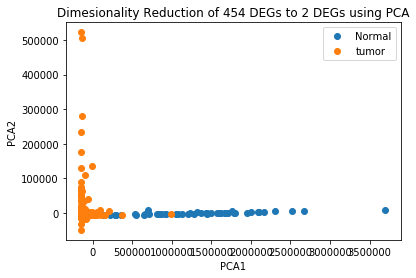

In [6]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)
# plt.scatter(X_pca[:,0],X_pca[:,1])

df2 = pd.DataFrame(dict(x=X_pca[:,0], y=X_pca[:,1], label=y))

groups = df2.groupby('label')

# Plot
fig, ax = plt.subplots()
ax.margins(0.05)
for name, group in groups:
    ax.plot(group.x, group.y, marker='.', linestyle='', ms=12, label=name)
ax.legend()
plt.title('Dimesionality Reduction of 454 DEGs to 2 DEGs using PCA')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.savefig('PCA_DSEQ2.png')
plt.show()

#### Generalized Function for Model Trian-Predict-Score

In [7]:
def try_model(model):
    clf_model = model
    clf_model.fit(X_train, y_train)
    y_pred = clf_model.predict(X_test)
#     print('Model:', str(model).split('(')[0])
#     print('Model parameters:', str(model))
#     print('confusion matrix', confusion_matrix(y_test,y_pred), sep='\n')
#     print(classification_report(y_test,y_pred))
#     print('accuracy score =', accuracy_score(y_test,y_pred))
#     print()
    return (str(model).split('(')[0], round(accuracy_score(y_test,y_pred), 2))

### Model #1: SVM

In [8]:
# SVM model (building the model [Linear])
svclassifier = SVC(kernel='linear')
svclassifier.fit(X_train, y_train)
# testing the model
y_pred = svclassifier.predict(X_test)
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))
print(accuracy_score(y_test,y_pred))

[[ 24   1]
 [  3 193]]
              precision    recall  f1-score   support

      Normal       0.89      0.96      0.92        25
       tumor       0.99      0.98      0.99       196

    accuracy                           0.98       221
   macro avg       0.94      0.97      0.96       221
weighted avg       0.98      0.98      0.98       221

0.9819004524886877


In [9]:
# GridSearch
parameters = {'C': [0.1, 1, 10, 100, 1000], 
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001], 
              'kernel': ['linear', 'poly', 'rbf', 'sigmoid']} 
# {'kernel':('linear', 'rbf'), 'C':[1, 10]}

grid = GridSearchCV(svclassifier, parameters)
grid.fit(X_train, y_train)
print(grid.best_params_)
print()
print(grid.best_estimator_) 
y_pred_2 = grid.predict(X_test)
print(confusion_matrix(y_test,y_pred_2))
print(classification_report(y_test,y_pred_2))
print(accuracy_score(y_test,y_pred_2))

{'C': 0.1, 'gamma': 1, 'kernel': 'linear'}

SVC(C=0.1, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=1, kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)
[[ 24   1]
 [  3 193]]
              precision    recall  f1-score   support

      Normal       0.89      0.96      0.92        25
       tumor       0.99      0.98      0.99       196

    accuracy                           0.98       221
   macro avg       0.94      0.97      0.96       221
weighted avg       0.98      0.98      0.98       221

0.9819004524886877


In [10]:
# No. of features vs. accuracy
acc_list = []
for i in range(1, df.shape[1]-1):
    X = df.iloc[:,list(range(i))]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.40, random_state=42)
    svc = SVC(kernel='linear')
    svc.fit(X_train, y_train)
    y_pred = svc.predict(X_test)
    acc_list.append(accuracy_score(y_test,y_pred))


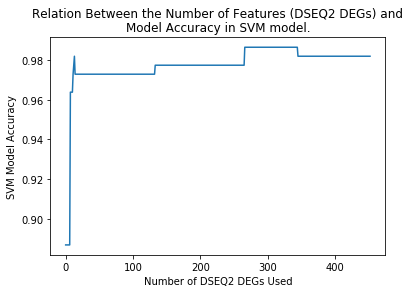

In [11]:
plt.plot(acc_list)
plt.title('\n'.join(wrap('Relation Between the Number of Features (DSEQ2 DEGs) and Model Accuracy in SVM model.', 60)))
plt.xlabel('Number of DSEQ2 DEGs Used')
plt.ylabel('SVM Model Accuracy')
plt.savefig('DEGsRSVM')
plt.show()

### Model #2: Linear Discriminant Analysis

LDA was first performed using R. Run this script to re-build the model <a href='final/NBLDA.r'>NB-LDA R model</a>.

In [12]:
param = {'solver' : ['svd','lsqr']}
lda = LinearDiscriminantAnalysis()

# building a basic model
lda.fit(X_train, y_train)
y_pred = lda.predict(X_test)
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))
print(accuracy_score(y_test,y_pred))
print()


# performing grid search analysis of the model
grid = GridSearchCV(lda, param)
grid.fit(X_train, y_train)
print(grid.best_params_)
print()
print(grid.best_estimator_) 
y_pred_2 = grid.predict(X_test)
print(confusion_matrix(y_test,y_pred_2))
print(classification_report(y_test,y_pred_2))
print(accuracy_score(y_test,y_pred_2))


[[ 21   4]
 [ 10 186]]
              precision    recall  f1-score   support

      Normal       0.68      0.84      0.75        25
       tumor       0.98      0.95      0.96       196

    accuracy                           0.94       221
   macro avg       0.83      0.89      0.86       221
weighted avg       0.94      0.94      0.94       221

0.9366515837104072

{'solver': 'svd'}

LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
                           solver='svd', store_covariance=False, tol=0.0001)
[[ 21   4]
 [ 10 186]]
              precision    recall  f1-score   support

      Normal       0.68      0.84      0.75        25
       tumor       0.98      0.95      0.96       196

    accuracy                           0.94       221
   macro avg       0.83      0.89      0.86       221
weighted avg       0.94      0.94      0.94       221

0.9366515837104072


### Model #3: Logistic Regression

In [13]:
LR = LogisticRegression()
LR.fit(X_train, y_train)
y_pred = LR.predict(X_test)
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))
print(accuracy_score(y_test,y_pred))
print()

[[ 25   0]
 [  3 193]]
              precision    recall  f1-score   support

      Normal       0.89      1.00      0.94        25
       tumor       1.00      0.98      0.99       196

    accuracy                           0.99       221
   macro avg       0.95      0.99      0.97       221
weighted avg       0.99      0.99      0.99       221

0.9864253393665159



### Model #4: Naive Bayes

In [14]:
NB = GaussianNB()
NB.fit(X_train, y_train)
y_pred = NB.predict(X_test)
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))
print(accuracy_score(y_test,y_pred))
print()

[[ 24   1]
 [  6 190]]
              precision    recall  f1-score   support

      Normal       0.80      0.96      0.87        25
       tumor       0.99      0.97      0.98       196

    accuracy                           0.97       221
   macro avg       0.90      0.96      0.93       221
weighted avg       0.97      0.97      0.97       221

0.9683257918552036



### Model #5: Decision Tree Classifier

[[ 25   0]
 [  3 193]]
              precision    recall  f1-score   support

      Normal       0.89      1.00      0.94        25
       tumor       1.00      0.98      0.99       196

    accuracy                           0.99       221
   macro avg       0.95      0.99      0.97       221
weighted avg       0.99      0.99      0.99       221

0.9864253393665159
1



[Text(167.4, 163.07999999999998, 'X[329] <= 5636.0\ngini = 0.135\nsamples = 330\nvalue = [24, 306]'),
 Text(83.7, 54.360000000000014, 'gini = 0.0\nsamples = 306\nvalue = [0, 306]'),
 Text(251.10000000000002, 54.360000000000014, 'gini = 0.0\nsamples = 24\nvalue = [24, 0]')]

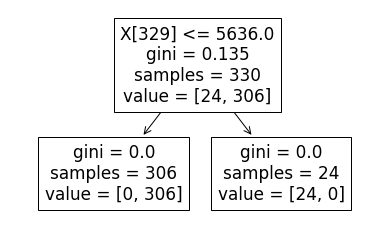

In [15]:
DTC = DecisionTreeClassifier()
dtc = DTC.fit(X_train, y_train)
y_pred = dtc.predict(X_test)
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))
print(accuracy_score(y_test,y_pred))
print(dtc.n_outputs_)
print()
plot_tree(dtc)

In [16]:
nn = np.array(dtc.feature_importances_, dtype=bool)

In [17]:
X.columns[nn]

Index(['PTPRB'], dtype='object')

In [18]:
dtc.get_depth()

1

[[ 24   1]
 [  4 192]]
              precision    recall  f1-score   support

      Normal       0.86      0.96      0.91        25
       tumor       0.99      0.98      0.99       196

    accuracy                           0.98       221
   macro avg       0.93      0.97      0.95       221
weighted avg       0.98      0.98      0.98       221

0.9773755656108597
1



[Text(167.4, 163.07999999999998, 'X[164] <= 625.5\nentropy = 0.376\nsamples = 330\nvalue = [24, 306]'),
 Text(83.7, 54.360000000000014, 'entropy = 0.0\nsamples = 306\nvalue = [0, 306]'),
 Text(251.10000000000002, 54.360000000000014, 'entropy = 0.0\nsamples = 24\nvalue = [24, 0]')]

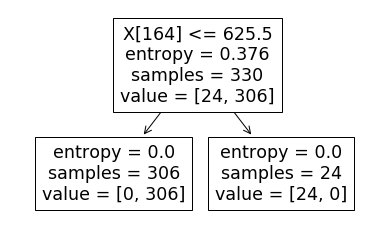

In [19]:
# information gain
DTC2 = DecisionTreeClassifier(criterion='entropy')
dtc2 = DTC2.fit(X_train, y_train)
y_pred = dtc2.predict(X_test)
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))
print(accuracy_score(y_test,y_pred))
print(dtc2.n_outputs_)
print()
plot_tree(dtc2)

### Model #6: Perceptron

In [20]:
clf = Perceptron()
clf.fit(X, y)
clf.score(X, y)

0.9927404718693285

### Model #7: Random Forest
This Python Notebook was used for RF >> <a href='Random_forest.ipynb'>Random Forst Classifier</a>.

### All Models Accuracy Table

In [21]:
models = [SVC(kernel='linear'), LinearDiscriminantAnalysis(), GaussianNB(), DecisionTreeClassifier(), Perceptron()]
model_results = {}
for model in models:
    key, val = try_model(model)
    model_results[key] = val
print(model_results)

{'SVC': 0.98, 'LinearDiscriminantAnalysis': 0.94, 'GaussianNB': 0.97, 'DecisionTreeClassifier': 0.96, 'Perceptron': 0.93}


In [22]:
model_results["RandomForest"] = 1.0
model_results["NB-LDA"] = 0.97
df2 = pd.DataFrame(list(model_results.values()), list(model_results.keys()))
df2.columns = ["Accuracy"]   
df2

,Accuracy
SVC,0.98
LinearDiscriminantAnalysis,0.94
GaussianNB,0.97
DecisionTreeClassifier,0.96
Perceptron,0.93
RandomForest,1.00
NB-LDA,0.97


## Results and Discussion

The aim of this project was to (1) identify the genes (features) whose expression values best differentiates between lung squamous carcinoma (LUSC) and normal lung cells: the differentially expressed genes (DEGs), and (2) identify the best ML model that can be used to classify LUSC vs. mormal cells based on those models.

For identifying the DEGs, DEGS identified via DSEQ2 algorithm (Script in R) showed better behavior than the DEGs identified by Gini index (the criterion used in decision trees) as shown in the line graphs of both.

For the machine learning model, a comparison between the models is shown in the above cell. Both random forest and
support vector machine (SVM) with linear classifying boundary showed the best behavior with accuracy of 99.55% and 98.20%, respectively. This is consistent with the PCA figures plotted before.

